# Matching Satellite and Buoy Data

In this exercise, you will combine satellite and buoy data by extracting satellite measurements around specific points defined by buoy locations and dates.  The focus of this exercise is on matching two data sources from different projections.  
Similar tutorials for mid to lower latitudes can be found at [https://github.com/coastwatch-training/CoastWatch-Tutorials](https://github.com/coastwatch-training/CoastWatch-Tutorials?tab=readme-ov-file#readme).

## This exercise demonstrates the following techniques:
- Using ERDDAP to retrieve buoy data in CSV format and satellite data in netCDF format
- Importing and manipulating data with the pandas and xarray libraries
- Resampling data to lower-resolution time steps
- Converting latitude and longitude coordinates to the polar stereographic projection


### Data used in this exercise


__[Ice Surface Temperature, NOAA-20 VIIRS, Near Real-Time, Polar Stereographic (North), 4-day](https://polarwatch.noaa.gov/erddap/info/noaacwVIIRSn20icesrftempNP06Daily4Day/index.html
)__

This dataset provides VIIRS sea ice surface temperature for the Arctic at a 750m resolution, collected by the NOAA-20 satellite. It includes near-real-time daily data and 4-day composites for the past three weeks. For this exercise, we will use 4-day composites data.  


__[International Arctic Buoy Programme (IABP) Buoy Data, Daily](https://polarwatch.noaa.gov/erddap/info/iabpv2_buoys/index.html)__

This data set is from the US International Arctic Buoy Programme and includes meteorological and oceanographic data from buoys. Dataset is updated daily and includes multiple variables.  For this exercise, we will extract surface temperature data. 


While both instruments measure surface temperatures, they do so at different locations and with different sensors.

__Satellite Ice Surface Temperature (IST)__ is measured by the Visible Infrared Imaging Radiometer Suite (VIIRS) and captures the temperature of the surface layer of ice.

__Buoy Surface Temperature (Ts)__ is measured from the bottom of the buoy hull. If the buoy is floating, the reported temperature is of the sea surface. If the buoy is frozen into the ice or sitting on top of it, the reported temperature is of the ground or ice. The freezing temperature of seawater is about -1.8°C, so temperature readings below this indicate ground or ice temperatures.

More details can be found in the metadata section of the data products (click on the data links above).

### Load packages




In [2]:
import xarray as xr
import pandas as pd
import requests
import io
import pyproj
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
from sklearn.metrics import r2_score 
import cartopy.crs as ccrs # cartopy: geospatial data visualization
import cartopy.feature as cfeature


### Load buoy data (IABP) from PolarWatch ERDDAP data server
* Construct ERDDAP URL to query the IABP buoy for: buoy_id, longitude, latitude, time, and surface temperature that filters for data where surface_temp exists and for the date range between 2023-08-01 and 2023-09-30.
* Download the data into a Pandas dataframe.

In [4]:
# Construct ERDDAP URL
buoy_url = ''.join(['https://polarwatch.noaa.gov/erddap/tabledap/iabpv2_buoys.csv?',
                    'buoy_id,longitude,latitude,time,surface_temp',
                    '&has_surface_temp="yes"&time>=2023-08-01&time<=2023-09-30'
                    ])

# Make a request to the ERDDAP server
req = requests.get(buoy_url).content

# The response from the web service is read as a CSV file into a pandas DataFrame. 
df = pd.read_csv(io.StringIO(req.decode('utf-8')), skiprows=[1], parse_dates=['time'])

df.head(3)



,buoy_id,longitude,latitude,time,surface_temp
0,300234066034140,-28.5226,55.0168,2023-08-01 00:00:00+00:00,13.5
1,300234066034140,-28.5226,55.0168,2023-08-01 01:00:02+00:00,13.4
2,300234066034140,-28.5226,55.0168,2023-08-01 01:59:57+00:00,13.4


### Select one buoy and process data 
Select one buoy  (buoy id = "300534062897730"). The buoy records measurements at intervals of minutes, resulting in a high-resolution dataset. , 
* Downsample the buoy data to align it with the daily resolution of the satellite dataset.  
* The time data is recorded in the UTC time zone. Pandas operations often encounter issues with time zones, so remove the time zone information for easier processing.

In [5]:
# Select one buoy (buoy id = "300534062897730")
buoy_df = df.loc[df["buoy_id"]== 300534062897730]

print('# of timesteps before =', buoy_df.shape[0] )

# The resampling will put time as the df index
buoy_df_resampled = buoy_df.resample('D', on='time').mean()
print('# of timesteps after =', buoy_df_resampled.shape[0] )

# Remove the timezone (UTC, GMT).
buoy_df_resampled = buoy_df_resampled.tz_localize(None)

# Rename the variable
buoy_df_resampled.rename(columns={"surface_temp": "temp_buoy"},
                         errors="raise",
                         inplace=True)

buoy_df_resampled.head(2)

# of timesteps before = 8523
# of timesteps after = 60


,buoy_id,longitude,latitude,temp_buoy
time,,,,
2023-08-01,3.005341e+14,-143.782008,86.385202,2.193916
2023-08-02,3.005341e+14,-143.104535,86.333932,1.520208


### Transform buoy coordinates to polar projection

The buoy locations are provided in latitude and longitude coordinates. The satellite data is in polar stereographic projection, which provided location in columns and rows with units of meters. 
* Convert the buoy locations from latitude and longitude to the corresponding columns and rows values in the polar projection.

In [6]:
# Define the projection using the PROJ4 string format
proj4text = "+proj=stere +lat_0=90 +lat_ts=70 +lon_0=-45 +k=1 +x_0=0 +y_0=0 +datum=WGS84 +units=m +no_defs"

# Initialize the projection object using pyproj with the given PROJ4 text
proj = pyproj.Proj(proj4text)

# Transform latitude and longitude to x, y coordinates
# Longitude and latitude are passed as arrays, 
# pyproj returns the corresponding x (cols) and y (rows) values
buoy_df_resampled['cols'], buoy_df_resampled['rows'] = proj(buoy_df_resampled['longitude'].values, 
                                                            buoy_df_resampled['latitude'].values)

# Verify that the 'cols' and 'rows' columns were added to dataframe
buoy_df_resampled.head(2)

,buoy_id,longitude,latitude,temp_buoy,cols,rows
time,,,,,,
2023-08-01,3.005341e+14,-143.782008,86.385202,2.193916,-387113.857367,59803.924517
2023-08-02,3.005341e+14,-143.104535,86.333932,1.520208,-393297.704017,56006.315907


In [7]:
# Select the first buoy location to pull corresponding satellite data
buoy_cols = buoy_df_resampled['cols'].iloc[0]
buoy_rows = buoy_df_resampled['rows'].iloc[0]

### Load satellite data from PolarWatch

In [8]:
# Construct ERDDAP data request
gridded_url = "https://polarwatch.noaa.gov/erddap/griddap/noaacwVIIRSn20icesrftempNP06Daily4Day"

# Open and load data into xarray dataset
srftemp_ds = xr.open_dataset(gridded_url)

# The altitude dimension has a size of 1, remove it to reduce the dimensionality
srftemp_ds = srftemp_ds.squeeze()

### Select satellite data to match buoy location and dates

Subset the satellite data using the buoy locations and dates.

In [19]:
buoy_cols = buoy_df_resampled['cols'].values
buoy_rows = buoy_df_resampled['rows'].values
buoy_times = buoy_df_resampled.index.values

sat_temps =[]
for ct, buoy_col in enumerate(buoy_cols):
    sat_temp = srftemp_ds['IceSrfTemp'].sel(
                     rows=buoy_rows[ct],
                     cols=buoy_col, 
                     time=buoy_times[ct],
                     method='nearest'
                     )
    
    sat_temps.append(sat_temp.values.item())

### Merge satellite ice temperature data with buoy  
Merge the datasets by index (date). Not all buoy dates have corresponding satellite data. Unmatched dates will be filled with NaN values.

In [76]:
merged_df = buoy_df_resampled

merged_df['temp_sat'] = np.array(sat_temps) - 273.15

merged_df.head(3)

,buoy_id,longitude,latitude,temp_buoy,cols,rows,temp_sat
time,,,,,,,
2023-08-01,3.005341e+14,-143.782008,86.385202,2.193916,-387113.857367,59803.924517,-0.413336
2023-08-02,3.005341e+14,-143.104535,86.333932,1.520208,-393297.704017,56006.315907,NaN
2023-08-03,3.005341e+14,-142.195432,86.271987,0.803264,-400800.933610,50600.465317,NaN


### Visualize matched dataSets
Visualize the matched buoy and satellite datasets to assess the data alignment. 

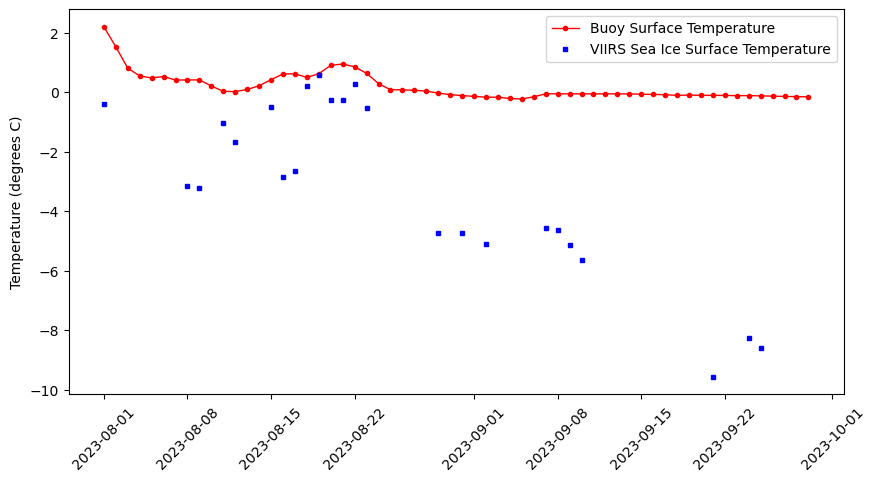

In [79]:
plt.figure(figsize = (10, 5)) 
# Plot the SeaWiFS data
plt.plot_date(merged_df.index, merged_df.temp_buoy, 
              'o', markersize=3, 
              label='Buoy Surface Temperature', c='red', 
              linestyle='-', linewidth=1) 

# Add MODIS data
plt.plot_date(merged_df.index, merged_df.temp_sat,  
              's', markersize=3, 
              label='VIIRS Sea Ice Surface Temperature', c='blue', 
              linestyle='-', linewidth=0) 

#plt.ylim([0, 3])
plt.ylabel('Temperature (degrees C)') 
plt.xticks(rotation=45)
plt.legend()